# Initialize Notebook

In [26]:
%%capture
!pip install xgboost
!pip install -U imbalanced-learn
!pip install -U graphviz
import warnings
warnings.filterwarnings('ignore')
#from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pylab import rcParams
import seaborn as sns

project_id = 'vertex-339105'  ###BQ Dataset Project ID
dataset = 'checkride'  
dataset_id = project_id + '.' + dataset

# BigQuery Magic

#@bigquery
select * from vertex-339105.checkride.training_data limit 100

In [27]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """select * from vertex-339105.checkride.training_data limit 100"""
job = client.query(query)
df = job.to_dataframe()

In [28]:
%%capture
%%bigquery training_data
select * from vertex-339105.checkride.training_data

In [29]:
%%capture
%%bigquery card_transactions
select * from vertex-339105.checkride.card_transactions;

In [30]:
card_transactions.head()

,cc_number,trans_id,trans_time,epoch_time,category,merchant,merchant_lat,merchant_lon,amount,is_fraud,trans_date
0,3515348437739019,4ef393cfada3067309f04ff3c1e83440,12:55:46,1458046546,kids_pets,"Romaguera, Wehner and Tromp",39.014361,-104.486472,229.27,False,2017-03-15
1,3515348437739019,93326a5aec5e950f6c60850e87eba063,13:10:21,1458047421,kids_pets,"Hauck, Dietrich and Funk",38.699423,-104.783995,12.65,False,2017-03-15
2,3515348437739019,8b7b2644ba753a8b7f6b1468ace3f792,16:07:39,1458058059,shopping_pos,Pacocha-Bauch,39.050688,-105.535286,3.42,False,2017-03-15
3,5224966038869005,2fff178b7c5724649b8dcc843e8c6b7b,08:13:24,1458029604,grocery_pos,Rutherford-Mertz,39.817273,-105.469108,48.05,False,2017-03-15
4,4745033884442,fcb78381b077a1e4931e990cdcad824e,18:13:01,1458065581,entertainment,"Schroeder, Hauck and Treutel",38.439027,-104.739258,26.85,False,2017-03-15


Total # of Fraudulent Tx: 3245
Total # of Non-Fraudulent Tx: 1334154
Proportion of Fraudulent Tx: 0.243%


<AxesSubplot:>

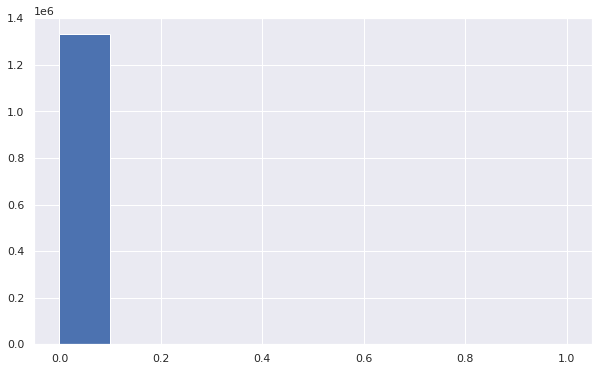

In [31]:
# Check Class Imbalance
fraud = len(training_data[training_data['is_fraud'] == True])
nonfraud = len(training_data[training_data['is_fraud'] != True])
print('Total # of Fraudulent Tx: {:.0f}'.format(fraud))
print('Total # of Non-Fraudulent Tx: {:.0f}'.format(nonfraud))
print('Proportion of Fraudulent Tx: {:.3f}%'.format(fraud/nonfraud*100))
training_data.is_fraud.astype(float).hist()

# Train a Baseline Model



<div>
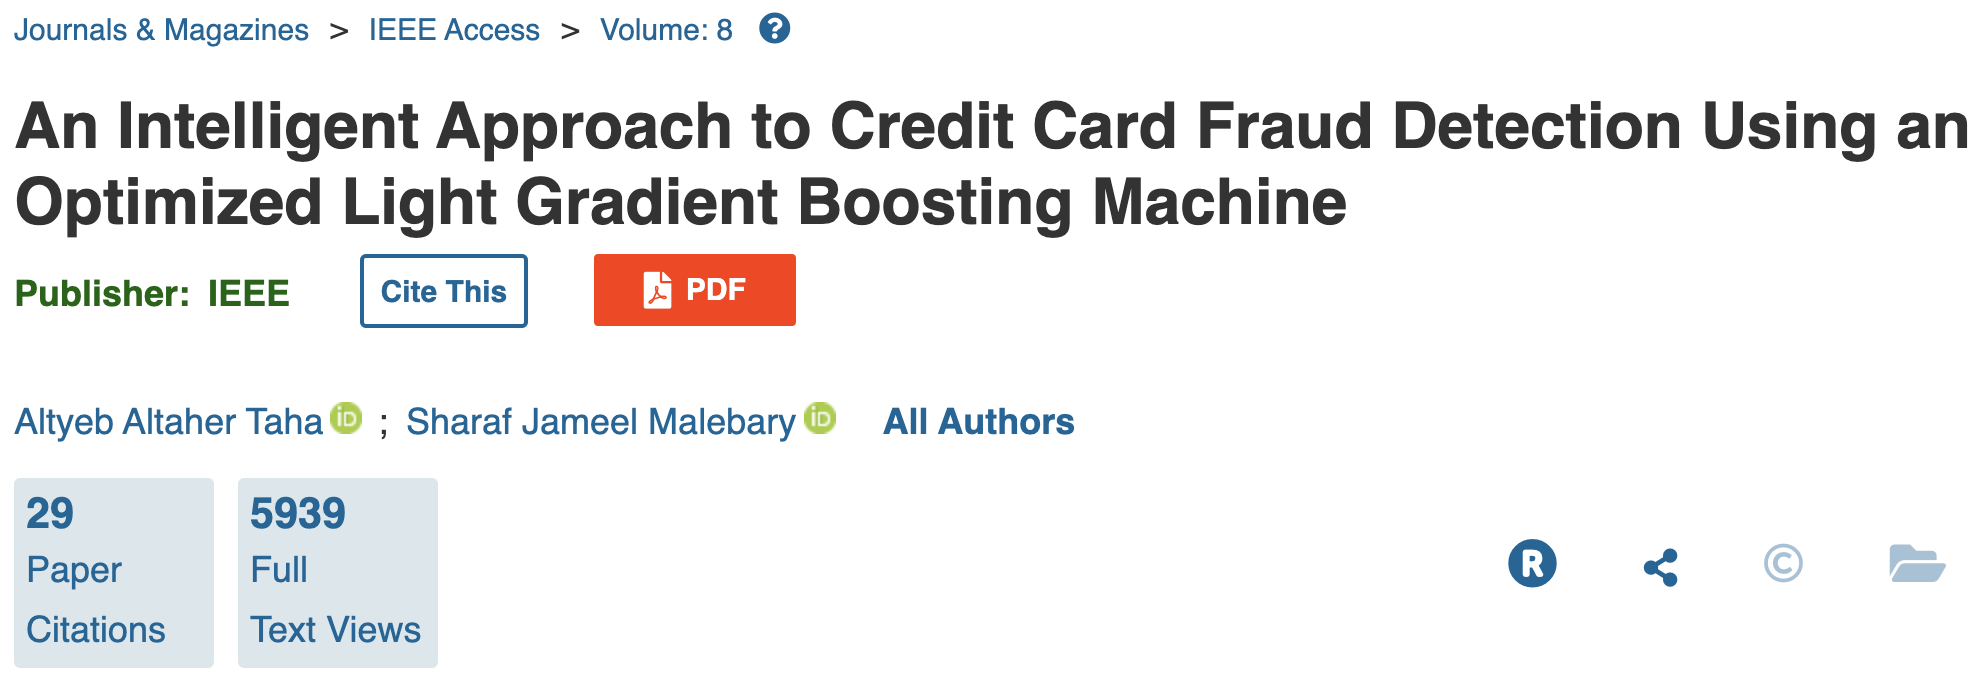<br>
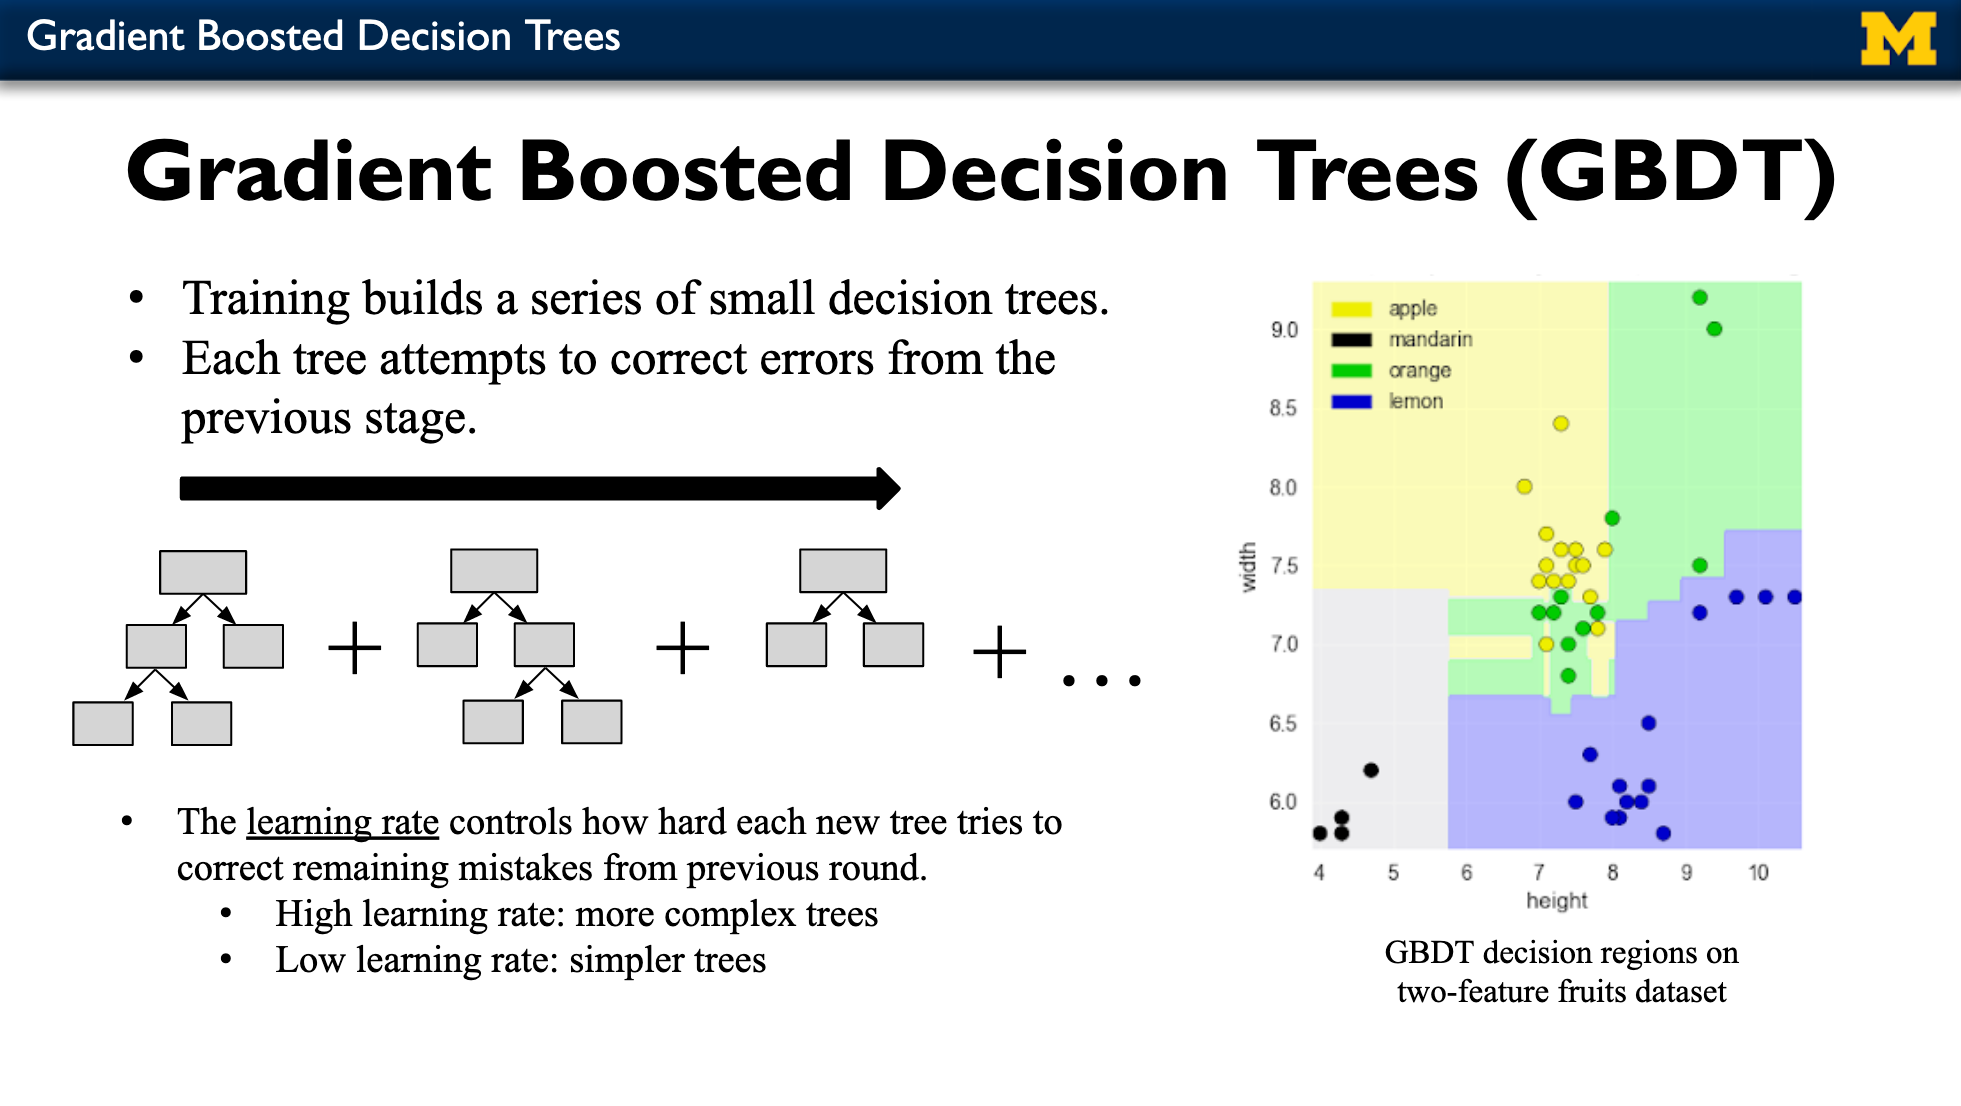
</div>



In [32]:
# Baseline - Step 1: Train a baseline model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

X = training_data.set_index('trans_id')
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,-3:], X.is_fraud, random_state = 0)

#lr_clf = LogisticRegression().fit(X_train, y_train)
lr_clf = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
#lr_clf = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

y_test.astype(str).value_counts(), y_train.astype(str).value_counts()

(False    333547
 True        803
 Name: is_fraud, dtype: int64,
 False    1000607
 True        2442
 Name: is_fraud, dtype: int64)

Accuracy of baseline classifier on training set: 0.997566420
Accuracy of baseline classifier on test set: 0.997598325
Accuracy: 0.99760
Precision: 0.00000
Recall: 0.00000
F1: 0.00000
Confusion Matrix (Baseline Classifier)
 [[333547      0]
 [   803      0]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.00      0.00      0.00       803

    accuracy                           1.00    334350
   macro avg       0.50      0.50      0.50    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (Baseline_model)')

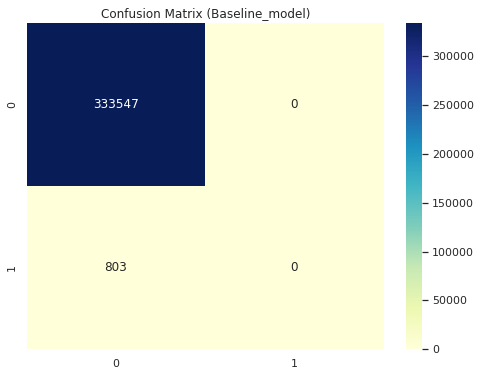

In [33]:
# Baseline - Step 2: Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


print('Accuracy of baseline classifier on training set: {:.9f}'
     .format(lr_clf.score(X_train, y_train)))
print('Accuracy of baseline classifier on test set: {:.9f}'
     .format(lr_clf.score(X_test, y_test)))

lr_predicted = lr_clf.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, lr_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, lr_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, lr_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, lr_predicted)))

print('Confusion Matrix (Baseline Classifier)\n', confusion)

print(classification_report(y_test, lr_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (Baseline_model)')

# Feature Exploration

### Transaction Amount - Log transformation

In [34]:
training_data.head()

,trans_id,is_fraud,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day
0,5df2e4e157360e161dec3d0efcc07113,True,280.52,91969.612014,0
1,56a4aa3f26687f98625fb811aa27c1c1,True,316.06,118693.486710,0
2,42b451600d91afd85d680581394a9de4,True,1006.36,41594.869210,0
3,13cd837b85bb9f779c3265a72d4315e2,True,271.33,56662.386364,0
4,579b3a883b4030d91475428af9407c56,True,904.47,48332.349503,0


In [35]:
card_transactions.head()

,cc_number,trans_id,trans_time,epoch_time,category,merchant,merchant_lat,merchant_lon,amount,is_fraud,trans_date
0,3515348437739019,4ef393cfada3067309f04ff3c1e83440,12:55:46,1458046546,kids_pets,"Romaguera, Wehner and Tromp",39.014361,-104.486472,229.27,False,2017-03-15
1,3515348437739019,93326a5aec5e950f6c60850e87eba063,13:10:21,1458047421,kids_pets,"Hauck, Dietrich and Funk",38.699423,-104.783995,12.65,False,2017-03-15
2,3515348437739019,8b7b2644ba753a8b7f6b1468ace3f792,16:07:39,1458058059,shopping_pos,Pacocha-Bauch,39.050688,-105.535286,3.42,False,2017-03-15
3,5224966038869005,2fff178b7c5724649b8dcc843e8c6b7b,08:13:24,1458029604,grocery_pos,Rutherford-Mertz,39.817273,-105.469108,48.05,False,2017-03-15
4,4745033884442,fcb78381b077a1e4931e990cdcad824e,18:13:01,1458065581,entertainment,"Schroeder, Hauck and Treutel",38.439027,-104.739258,26.85,False,2017-03-15


<AxesSubplot:xlabel='amount', ylabel='Density'>

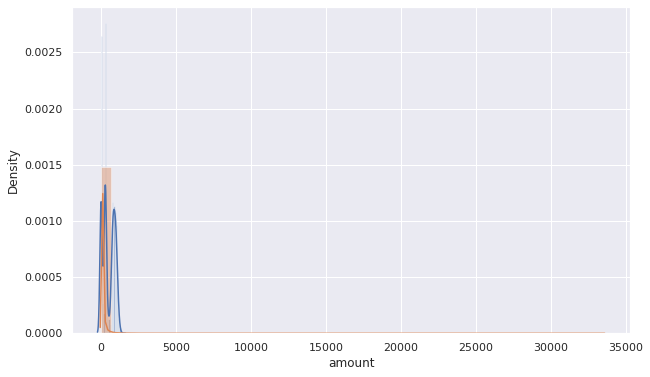

In [36]:
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot((card_transactions[card_transactions['is_fraud'] == True].amount))
sns.distplot((card_transactions[card_transactions['is_fraud'] != True].amount))
#sns.distplot(np.log(card_transactions[card_transactions['is_fraud'] == True].amount))
#sns.distplot(np.log(card_transactions[card_transactions['is_fraud'] != True].amount))
#sns.distplot(training_data[training_data['is_fraud'] == True].card_transactions_transaction_distance)
#sns.distplot(training_data[training_data['is_fraud'] != True].card_transactions_transaction_distance)

### Transaction Category

<AxesSubplot:xlabel='category', ylabel='Count'>

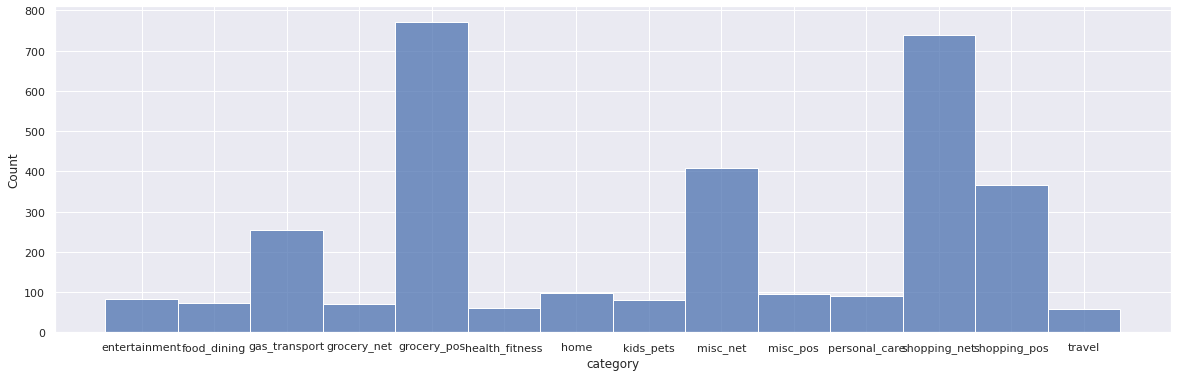

In [37]:
#Feature Exploration

sns.set(rc={'figure.figsize':(20,6)})
sns.histplot(card_transactions[card_transactions['is_fraud'] == True].category.sort_values())

#card_transactions[card_transactions['is_fraud'] == True].category.hist()
#card_transactions[card_transactions['is_fraud'] != True].category.hist()

<AxesSubplot:xlabel='category', ylabel='Count'>

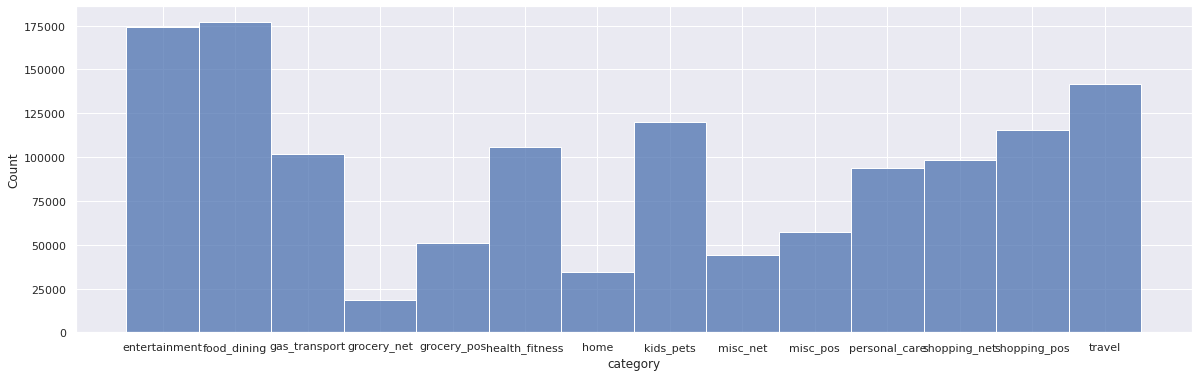

In [38]:
#card_transactions[card_transactions['is_fraud'] != True].category.hist()
sns.histplot(card_transactions[card_transactions['is_fraud'] != True].category.sort_values())

## Use Google Sheets for Feature Exploration

https://docs.google.com/spreadsheets/d/1_ioZCt-oTn9WSkC5B4PfjNe98l2oHHEmIGIL_1MPylg/edit#gid=487637754

# Train a Model with Transaction Category (One-Hot Encoding)

In [39]:
###### Merge Tx merchant category and transform to One Hot Encoding

new_set = training_data.merge(card_transactions[['trans_id','category']], on='trans_id')
new_set = pd.get_dummies(new_set,prefix=['category'], columns = ['category'], drop_first=True)#.drop('card_transactions_transaction_distance',axis=1)
X = new_set.set_index('trans_id')
X.iloc[:,-16:]

,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
trans_id,,,,,,,,,,,,,,,,
5df2e4e157360e161dec3d0efcc07113,280.52,91969.612014,0,0,0,0,1,0,0,0,0,0,0,0,0,0
56a4aa3f26687f98625fb811aa27c1c1,316.06,118693.486710,0,0,0,0,1,0,0,0,0,0,0,0,0,0
42b451600d91afd85d680581394a9de4,1006.36,41594.869210,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13cd837b85bb9f779c3265a72d4315e2,271.33,56662.386364,0,0,0,0,1,0,0,0,0,0,0,0,0,0
579b3a883b4030d91475428af9407c56,904.47,48332.349503,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78e696464be1791bc7f6f183d0e20c80,2.06,82900.812231,23,0,0,0,0,0,0,0,0,0,0,0,0,0
daa607f79119ff5d18fdc71ff7a71a98,77.87,80156.951029,23,0,1,0,0,0,0,0,0,0,0,0,0,0
3ff84bda701e1fded1ddc87374543570,66.02,46163.922620,23,0,1,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# Try a model using new training set

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,-16:], X.is_fraud, random_state = 0)

lr_clf = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)

y_test.astype(str).value_counts(), y_train.astype(str).value_counts()


(False    333547
 True        803
 Name: is_fraud, dtype: int64,
 False    1000607
 True        2442
 Name: is_fraud, dtype: int64)

Baseline Accuracy of Gradient Boosting classifier on training set: 0.998088827
Baseline Accuracy of Gradient Boosting classifier on test set: 0.998103783
Accuracy: 0.99810
Precision: 0.80287
Recall: 0.27895
F1: 0.41405
Confusion Matrix (Baseline Gradient Boosting Classifier)
 [[333492     55]
 [   579    224]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.80      0.28      0.41       803

    accuracy                           1.00    334350
   macro avg       0.90      0.64      0.71    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (Improved_model)')

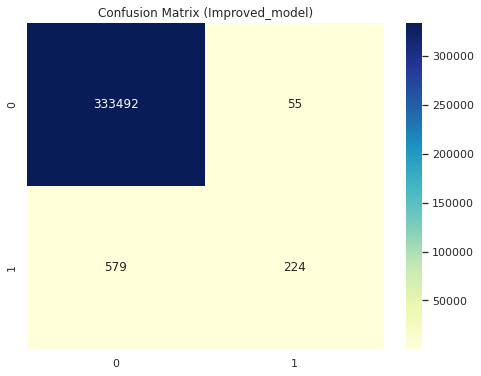

In [41]:
print('Baseline Accuracy of Gradient Boosting classifier on training set: {:.9f}'
     .format(lr_clf.score(X_train, y_train)))
print('Baseline Accuracy of Gradient Boosting classifier on test set: {:.9f}'
     .format(lr_clf.score(X_test, y_test)))

lr_predicted = lr_clf.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, lr_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, lr_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, lr_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, lr_predicted)))

print('Confusion Matrix (Baseline Gradient Boosting Classifier)\n', confusion)

print(classification_report(y_test, lr_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (Improved_model)')

# Let's Try another Algorithm - XGBoost


<div>
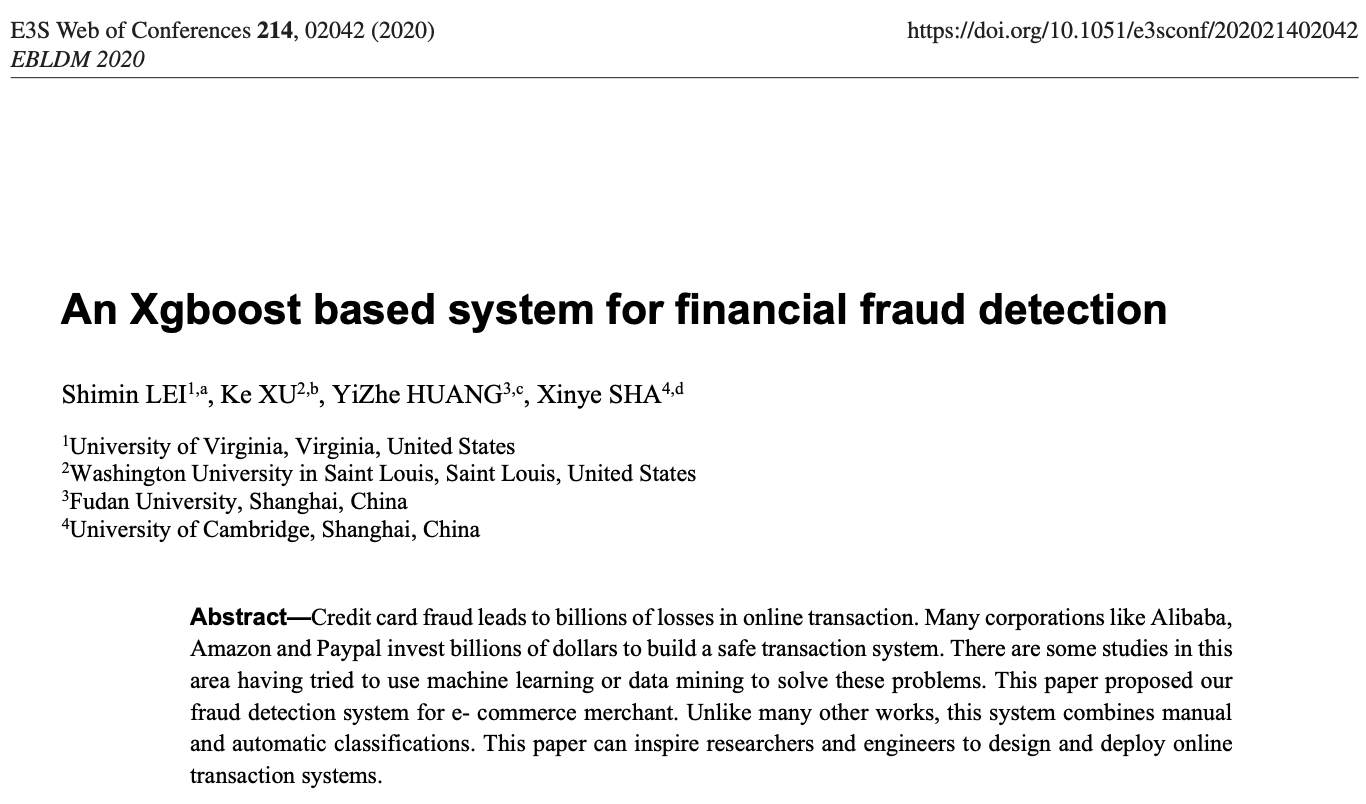
</div>

### Sci-Kit Learn (including most non Deep Learning model) don't benefit from running on GPUs
### GPU would benefit training on datasets with high dimension or large sample using supported Library 

https://cloud.google.com/ai-platform/training/docs/using-gpus

In [42]:
# Suppress all warnings
import xgboost as xgb

xg_clf = xgb.XGBClassifier(eval_metric="aucpr", #max_delta_step = 3,
                           max_depth=10,learning_rate=0.123,#scale_pos_weight=300,
                           use_label_encoder=False,
                           tree_method='gpu_hist',
                           random_state=0)
%time xg_clf.fit(X_train, y_train)

CPU times: user 1.56 s, sys: 305 ms, total: 1.87 s
Wall time: 1.11 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.123, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Baseline Accuracy of XGboost classifier on training set: 0.999520462
Baseline Accuracy of XGboost classifier on test set: 0.999189472
Accuracy: 0.99919
Precision: 0.90673
Recall: 0.73848
F1: 0.81400
Confusion Matrix (XGboost Classifier)
 [[333486     61]
 [   210    593]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.91      0.74      0.81       803

    accuracy                           1.00    334350
   macro avg       0.95      0.87      0.91    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (XGBoost_model)')

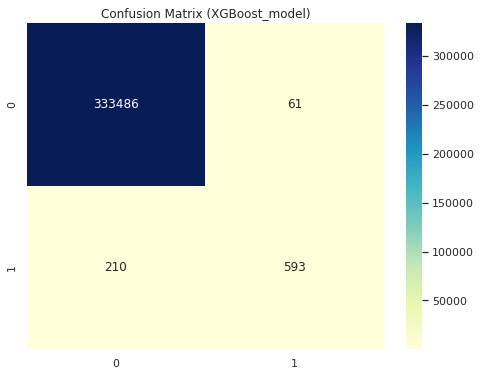

In [43]:
print('Baseline Accuracy of XGboost classifier on training set: {:.9f}'
     .format(xg_clf.score(X_train, y_train)))
print('Baseline Accuracy of XGboost classifier on test set: {:.9f}'
     .format(xg_clf.score(X_test, y_test)))

xg_predicted = xg_clf.predict(X_test)
confusion = confusion_matrix(y_test, xg_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, xg_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, xg_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, xg_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, xg_predicted)))

print('Confusion Matrix (XGboost Classifier)\n', confusion)

print(classification_report(y_test, xg_predicted, target_names=['not Fraud', 'Fraud']))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap='YlGnBu', annot = True, fmt='d')
ax.set_title('Confusion Matrix (XGBoost_model)')

<AxesSubplot:>

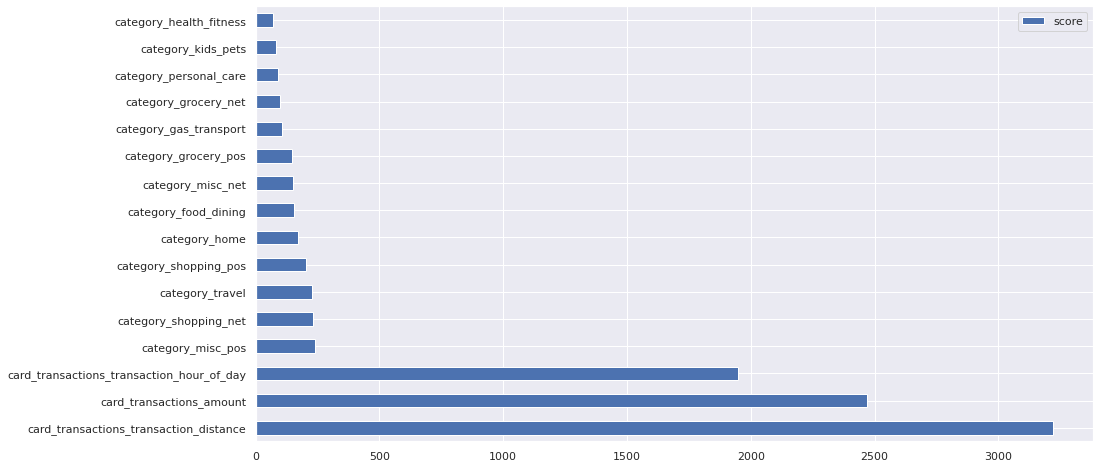

In [44]:
## Feature Importance

feature_important = xg_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

tmp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.nlargest(16, columns="score").plot(kind='barh', figsize = (15,8)) ## plot all 16 features

In [45]:
feature_important

{'card_transactions_amount': 2471.0,
 'card_transactions_transaction_distance': 3220.0,
 'card_transactions_transaction_hour_of_day': 1947.0,
 'category_food_dining': 153.0,
 'category_gas_transport': 108.0,
 'category_grocery_net': 100.0,
 'category_grocery_pos': 145.0,
 'category_health_fitness': 68.0,
 'category_home': 169.0,
 'category_kids_pets': 81.0,
 'category_misc_net': 150.0,
 'category_misc_pos': 240.0,
 'category_personal_care': 91.0,
 'category_shopping_net': 232.0,
 'category_shopping_pos': 203.0,
 'category_travel': 228.0}

# Try SMOTE - Oversampling 



<div>
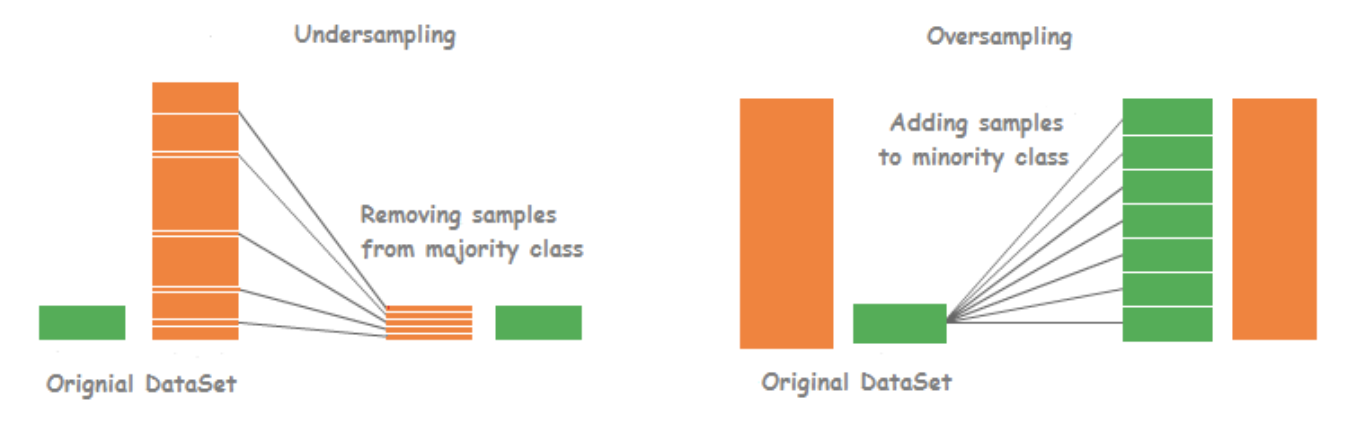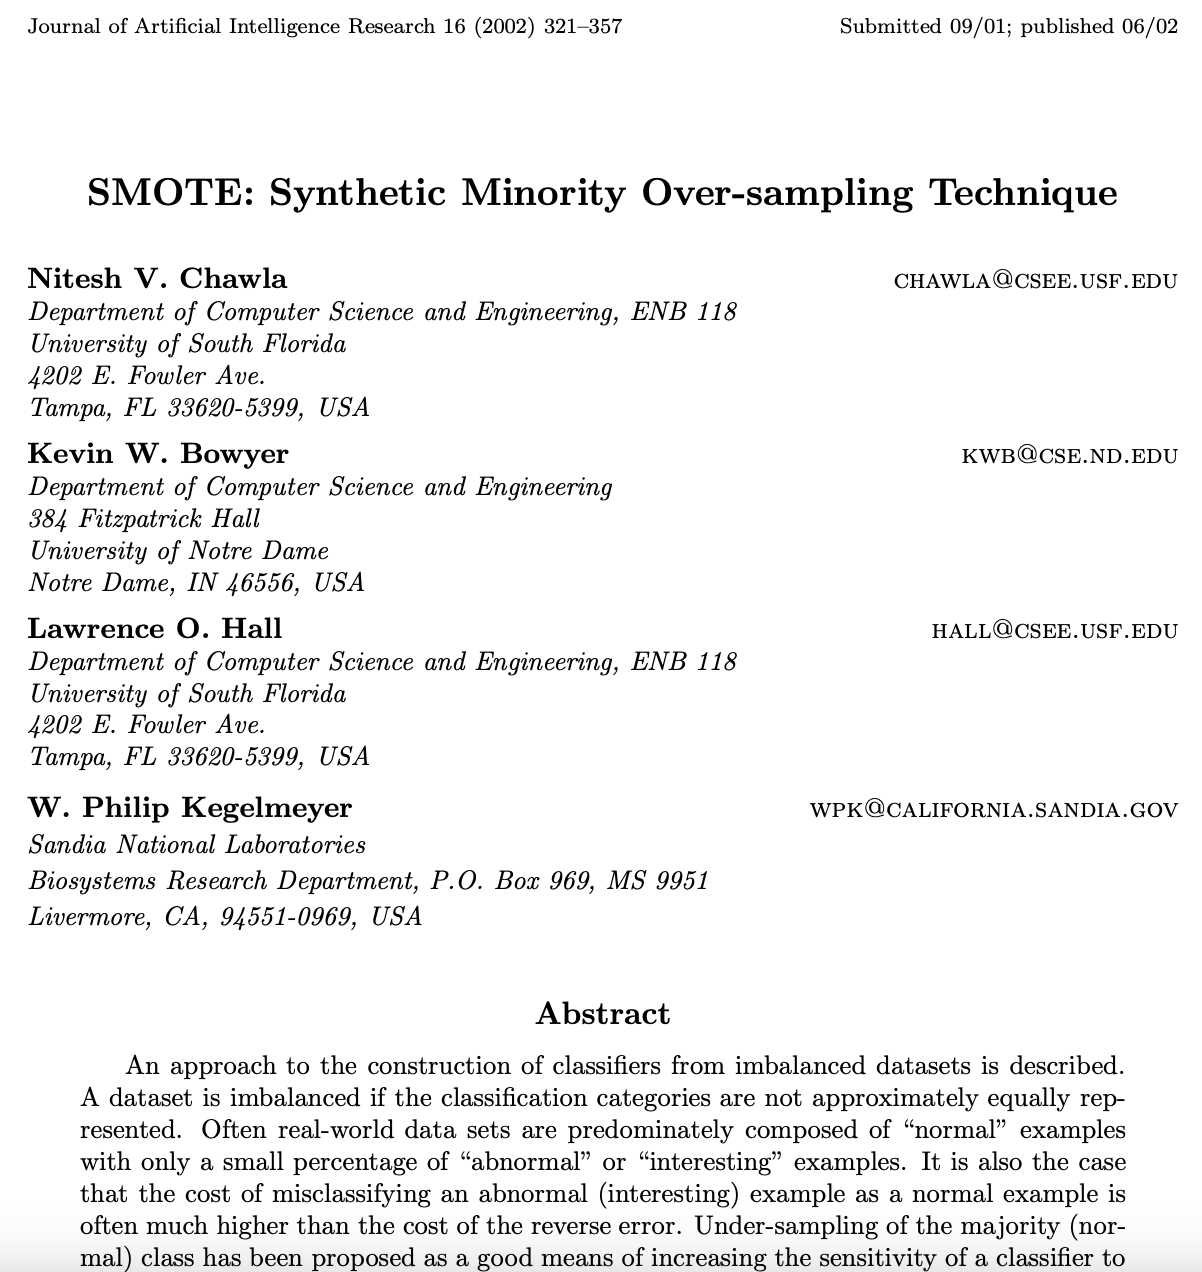
</div>
https://www.researchgate.net/publication/220543125_SMOTE_Synthetic_Minority_Over-sampling_Technique 


In [46]:
## Oversampling
#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority', random_state=999)
X_res, y_res = ros.fit_resample(X_train, y_train)
y_res.value_counts()

False    1000607
True     1000607
Name: is_fraud, dtype: int64

In [47]:
#ros_clf = xgb.XGBClassifier(eval_metric="aucpr", max_depth=8,use_label_encoder=False).fit(X_res, y_res)
ros_clf = xgb.XGBClassifier(
    #n_estimators=100,
    eval_metric="aucpr", 
    learning_rate=0.123,
    max_depth=10,
    use_label_encoder=False,
    tree_method='gpu_hist',
    random_state=0)

%time ros_clf.fit(X_res, y_res)

CPU times: user 2.84 s, sys: 602 ms, total: 3.45 s
Wall time: 1.91 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.123, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [48]:

print('Oversampled Accuracy of XGboost classifier on oversampled training set: {:.9f}'
     .format(ros_clf.score(X_res, y_res)))
print('Oversampled Accuracy of XGboost classifier on test set: {:.9f}'
     .format(ros_clf.score(X_test, y_test)))

ros_predicted = ros_clf.predict(X_test)
confusion = confusion_matrix(y_test, ros_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, ros_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, ros_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, ros_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, ros_predicted)))

print('Confusion Matrix (XGboost Classifier)\n', confusion)

print(classification_report(y_test, ros_predicted, target_names=['not Fraud', 'Fraud']))

Oversampled Accuracy of XGboost classifier on oversampled training set: 0.998998108
Oversampled Accuracy of XGboost classifier on test set: 0.997717960
Accuracy: 0.99772
Precision: 0.51425
Recall: 0.89913
F1: 0.65428
Confusion Matrix (XGboost Classifier)
 [[332865    682]
 [    81    722]]
              precision    recall  f1-score   support

   not Fraud       1.00      1.00      1.00    333547
       Fraud       0.51      0.90      0.65       803

    accuracy                           1.00    334350
   macro avg       0.76      0.95      0.83    334350
weighted avg       1.00      1.00      1.00    334350



Text(0.5, 1.0, 'Confusion Matrix (final_model)')

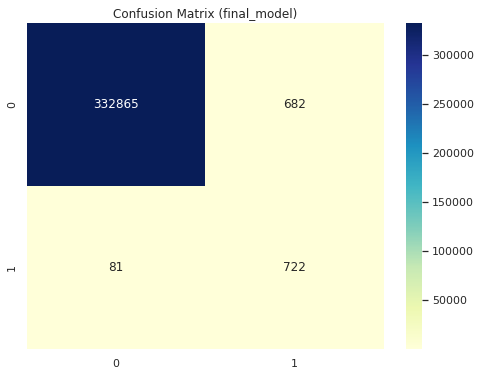

In [49]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

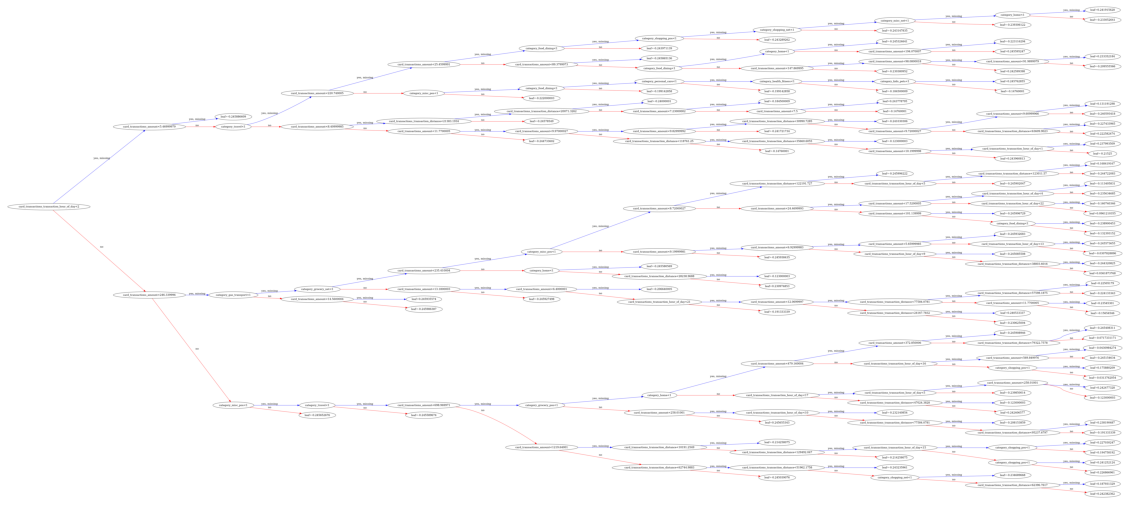

In [50]:

from xgboost import plot_tree

rcParams['figure.figsize'] = 20,15
#figure(figsize=(18, 16))
plot_tree(ros_clf,rankdir='LR')
#plt.show()
plt.savefig('xgb_tree.png')

## From 0 to 90%

<div>
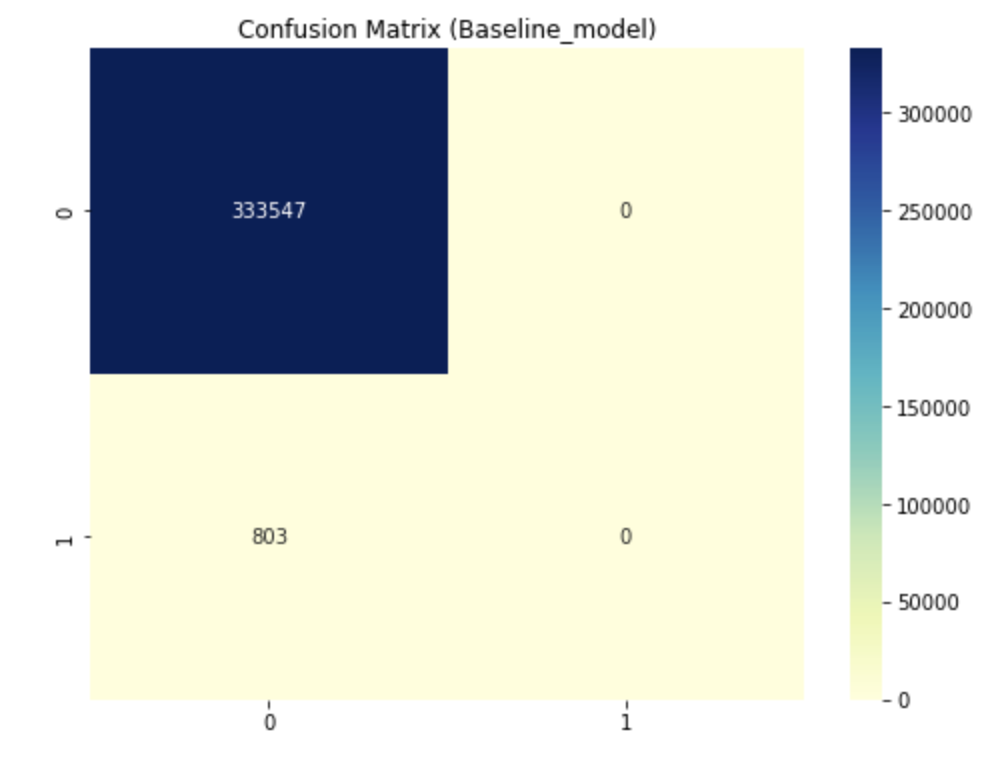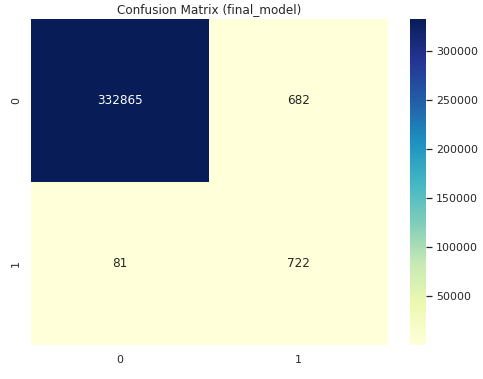
</div>

# Let's Put It altogether on Google Cloud
https://pantheon.corp.google.com/vertex-ai/training/training-pipelines?project=vertex-339105

## Create a new table in BigQuery to store category data as well

### BigQuery SQL Query Here:

CREATE OR REPLACE TABLE vertex-339105.checkride.new_train as(
select train.is_fraud, train.card_transactions_amount, 
train.card_transactions_transaction_distance, train.card_transactions_transaction_hour_of_day,
card.category
from vertex-339105.checkride.training_data as train
INNER JOIN vertex-339105.checkride.card_transactions as card ON train.trans_id=card.trans_id
)

### BigQuery ML Create Boosting Tree Model:

CREATE OR REPLACE MODEL checkride.BT_model
OPTIONS(model_type='BOOSTED_TREE_CLASSIFIER', labels=['is_fraud']) AS
SELECT * 
FROM checkride.new_train
WHERE (is_fraud IS TRUE) OR
(is_fraud IS NOT TRUE AND rand() <=
(SELECT COUNTIF(is_fraud)/COUNT(*) FROM checkride.new_train));

### BigQuery ML Create AutoML Model:
CREATE OR REPLACE MODEL checkride.BT_model
OPTIONS(model_type='AUTOML_CLASSIFIER', 
        INPUT_LABEL_COLS=['is_fraud'],
        OPTIMIZATION_OBJECTIVE = 'MAXIMIZE_AU_PRC',
        BUDGET_HOURS = 24
       ) AS
SELECT * 
FROM checkride.new_train
WHERE (is_fraud IS TRUE) OR
(is_fraud IS NOT TRUE AND rand() <=
(SELECT COUNTIF(is_fraud)/COUNT(*) FROM checkride.new_train));

In [51]:
%%bigquery df

select * from vertex-339105.checkride.new_train limit 10

Downloading: 100%|██████████| 10/10 [00:00<00:00, 11.55rows/s]


In [52]:
df

,is_fraud,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day,category
0,False,57.14,77987.351358,0,home
1,False,11.49,75065.237701,0,home
2,False,20.98,119448.888788,0,home
3,True,270.00,84567.151578,0,home
4,False,50.55,97981.170474,0,home
5,False,11.59,37905.245413,0,home
6,True,270.58,78240.948281,0,home
7,True,250.56,74687.455796,0,home
8,False,28.84,76108.345520,0,home
9,False,21.16,35451.824655,0,home


In [53]:
# Download all tables in the BigQuery Dataset.

def bq_table(table_name):
    bqclient = bigquery.Client()
    
    table = project_id + '.' + dataset + '.' + table_name
    
    rows = bqclient.list_rows(
        bigquery.TableReference.from_string(table)#,
        #selected_fields=[
        #    bigquery.SchemaField("country_name", "STRING"),
        #    bigquery.SchemaField("fips_code", "STRING"),
        #],
    )
    df = rows.to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
    return df

#for table in bigquery.Client().list_tables(dataset_id):
    # print("{}".format(table.table_id))
#    globals()[table.table_id] = bq_table(table.table_id)

<AxesSubplot:xlabel='card_transactions_transaction_distance', ylabel='Density'>

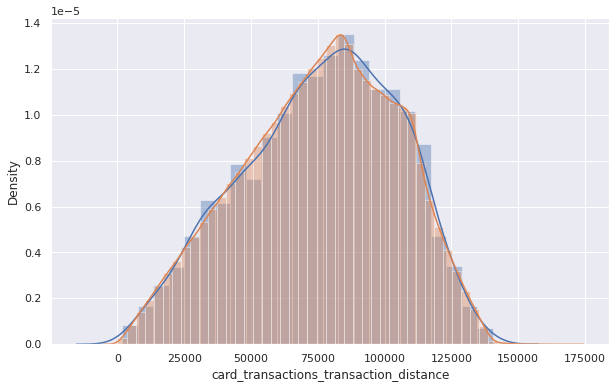

In [54]:
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(training_data[training_data['is_fraud'] == True].card_transactions_transaction_distance)
sns.distplot(training_data[training_data['is_fraud'] != True].card_transactions_transaction_distance)

In [55]:
%%capture
%%bigquery card_payment_amounts
select * from vertex-339105.checkride.card_payment_amounts

In [56]:
max_monthy_tx = card_payment_amounts.groupby('card_number').period_transactions_total.max().reset_index()
max_monthy_tx["card_number"] = pd.to_numeric(max_monthy_tx["card_number"])
max_monthy_tx["card_number"] = max_monthy_tx["card_number"].astype('int')
map_card = card_transactions.copy()
map_card = map_card.merge(max_monthy_tx, left_on='cc_number', right_on='card_number')


<AxesSubplot:>

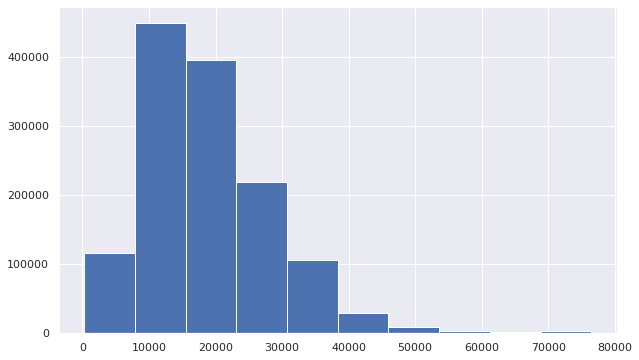

In [57]:
map_card[map_card['is_fraud'] != True].period_transactions_total.hist()#, map_card[map_card['is_fraud'] == True].period_transactions_total.hist()

In [58]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

X = training_data.set_index('trans_id')
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,-3:], X.is_fraud, random_state = 0)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority', random_state=999)
X_res, y_res = ros.fit_resample(X_train, y_train)
ros_clf = xgb.XGBClassifier(n_estimators=800,
                           eval_metric="aucpr", 
                           learning_rate=0.0015,
                           max_depth=12,
                           enable_categorical=True,
                           use_label_encoder=False,
                           tree_method='gpu_hist',
                           random_state=0).fit(X_res, y_res)
ros_predicted = ros_clf.predict(X_test)
confusion = confusion_matrix(y_test, ros_predicted)

# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, ros_predicted)))
print('Precision: {:.5f}'.format(precision_score(y_test, ros_predicted)))
print('Recall: {:.5f}'.format(recall_score(y_test, ros_predicted)))
print('F1: {:.5f}'.format(f1_score(y_test, ros_predicted)))

print('Confusion Matrix (XGboost Classifier)\n', confusion)

print(classification_report(y_test, ros_predicted, target_names=['not Fraud', 'Fraud']))

Accuracy: 0.98244
Precision: 0.10957
Recall: 0.88543
F1: 0.19501
Confusion Matrix (XGboost Classifier)
 [[327769   5778]
 [    92    711]]
              precision    recall  f1-score   support

   not Fraud       1.00      0.98      0.99    333547
       Fraud       0.11      0.89      0.20       803

    accuracy                           0.98    334350
   macro avg       0.55      0.93      0.59    334350
weighted avg       1.00      0.98      0.99    334350



In [59]:
training_data.head()

,trans_id,is_fraud,card_transactions_amount,card_transactions_transaction_distance,card_transactions_transaction_hour_of_day
0,5df2e4e157360e161dec3d0efcc07113,True,280.52,91969.612014,0
1,56a4aa3f26687f98625fb811aa27c1c1,True,316.06,118693.486710,0
2,42b451600d91afd85d680581394a9de4,True,1006.36,41594.869210,0
3,13cd837b85bb9f779c3265a72d4315e2,True,271.33,56662.386364,0
4,579b3a883b4030d91475428af9407c56,True,904.47,48332.349503,0
